In [1]:
#!pip install --upgrade ~/Development/repos/tradeframework
#!pip install --upgrade ~/Development/repos/tradeframework-insights
#!pip install --upgrade ~/Development/repos/quantutils
#!pip install --upgrade ~/Development/repos/marketinsights-price-aggregator

# Pkg imports
# TODO - dynamic import of SandboxEnv
from tradeframework.environments import SandboxEnvironment  
from marketinsights.api.aggregator import MarketDataAggregator
from marketinsights.remote.ml import MIAssembly
from marketinsights.remote.models import MIModelServer
import quantutils.dataset.pipeline as ppl
import quantutils.dataset.ml as mlutils

# Dev imports
import pandas as pd
import numpy as np

#import matplotlib
#%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

import warnings
warnings.filterwarnings(action='ignore')


2023-04-04 14:30:06.799149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 14:30:06.954534: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-04 14:30:06.954563: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-04 14:30:08.096480: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
modelsvr = MIModelServer(secret="marketinsights-k8s-cred")
assembly = MIAssembly(modelsvr, secret="marketinsights-k8s-cred")

In [3]:
data_config = [
    {
        "ID": "MDS",
        "class": "MDSConnector",
        "opts": {
            "location": "http://localhost:8080"
        },
        "timezone": "UTC",
        "markets": [
            {
                "ID": "DOW",
                "sources": [
                    {
                        "ID": "WallSt-hourly",
                        "sample_unit": "H"
                    },
                    {
                        "ID": "D&J-IND",
                        "sample_unit": "5min"
                    }
                ]
            },
            {
                "ID": "SPY",
                "sources": [
                    {
                        "ID":"SP500-hourly",
                        "sample_unit":"H"
                    },
                    {
                        "ID":"SANDP-500",
                        "sample_unit":"5min"
                    }
                ]
            }
        ]
    }
]


## Get Market Data
aggregator = MarketDataAggregator(data_config)
   
#start = "2013-01-01" # Train period
#end = "2018-08-01"

#start="2018-08-02" # Test period
#end="2018-12-31"

start="2018-08-02" # Test period
end="2025-12-31"

marketData = aggregator.getData(mkts=["DOW"], sample_unit="H", start=start, end=end, aggregate=True, debug=False)
print("Data Loaded")
#marketData = marketData.xs("mID")
#marketData = marketData.tz_convert("US/Eastern", level="Date_Time")
#marketData = marketData.unstack(level=0).dropna(axis=1).stack() # Remove rows that don't have values from all markets
#tickers = marketData.index.get_level_values("mID").unique().values


100%|██████████| 1/1 [00:07<00:00,  7.43s/it]

Data Loaded


In [123]:
env = SandboxEnvironment("TradeFair", "US/Eastern")
env.createAssets(marketData)

p = env.createDerivative("MyPortfolio", weightGenerator=env.createOptimizer("EqualWeightsOptimizer"))
env.setPortfolio(p)

# Create baseline as an unweighted asset
baseline = env.createDerivative("Baseline Signal", weightGenerator=env.createModel("BuyAndHold", opts={"barOnly": False}))
baseline.addStoredAsset(["DOW"])
p.addAsset(baseline, weighted=False)

# Create baseline as an unweighted asset
baseline2 = env.createDerivative("MaxReturn", weightGenerator=env.createModel("MaxReturn", opts={"start":"19:00", "end":"20:00", "barOnly": True}))
baseline2.addStoredAsset(["DOW"])
#p.addAsset(baseline2, weighted=False)

# Create baseline as an unweighted asset
baseline3 = env.createDerivative("MinReturn", weightGenerator=env.createModel("MinReturn", opts={"start":"19:00", "end":"20:00", "barOnly": True}))
baseline3.addStoredAsset(["DOW"])
#p.addAsset(baseline3, weighted=False)

# BuyAndHold
""" p.addAsset(
    env.createDerivative(
        "BuyAndHold", 
        weightGenerator=env.createModel(
            "BuyAndHold", 
            #opts={"start":"19:00", "end":"20:00", "barOnly": True}
            opts={"barOnly": False}
        )).addStoredAsset(["DOW"]))
 """
# ARIMA
p.addAsset(
    env.createDerivative(
        "ARIMA", 
        weightGenerator=ARIMA(env, AR=1, I=1, MA=3, window=24*5*4*3, fit="inSample", params=params, barOnly=True)).addStoredAsset(["DOW"]))

# ML Model
#p.addAsset(
#    env.createDerivative(
#        "mlmodel", 
#        weightGenerator=env.createModel(
#            "MIBasicModel", 
#            modelModule="tradeframework.models.remote",
#            opts={"window": 2, "modelSvr": modelsvr, "secret":"marketinsights-k8s-cred", "trainingRunId":"mlmodel", "threshold":0.8, "barOnly": True}
#        )).addStoredAsset(["DOW"]))

# Feed data into the portfolio
env.refresh()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [122]:
params = p.assets[1].weightGenerator.result.params

ARIMA:000, AIC:-6637.156677803146, MFE:4.994448498488629e-06, MAE:0.02606127092740817
ARIMA:010, AIC:-5627.725325290887, MFE:-1.0305893466325581e-05, MAE:inf
ARIMA:001, AIC:-6666.817417931898, MFE:5.595139401717496e-06, MAE:0.014954386072632275
ARIMA:011, AIC:-6623.3385729805295, MFE:-3.19304278634448e-05, MAE:inf
ARIMA:002, AIC:-6697.624774392927, MFE:3.0972943950108544e-06, MAE:0.002861757906411409
ARIMA:012, AIC:-6652.670521750577, MFE:-3.608802341898233e-05, MAE:inf
ARIMA:003, AIC:-6700.329892507509, MFE:3.701675092497706e-06, MAE:0.0012649778079308386
ARIMA:013, AIC:-6683.902818299128, MFE:-2.9729979161456735e-05, MAE:inf
ARIMA:004, AIC:-6698.730185626137, MFE:5.7932269145810806e-06, MAE:-0.0003906421279314114
ARIMA:014, AIC:-6685.40858046805, MFE:-3.93152053227188e-05, MAE:inf
ARIMA:100, AIC:-6676.372674410941, MFE:4.433966625642799e-06, MAE:-0.014132144914355414
ARIMA:110, AIC:-6262.218145344214, MFE:-3.88998202450866e-06, MAE:inf
ARIMA:101, AIC:-6683.247563334575, MFE:3.5935324

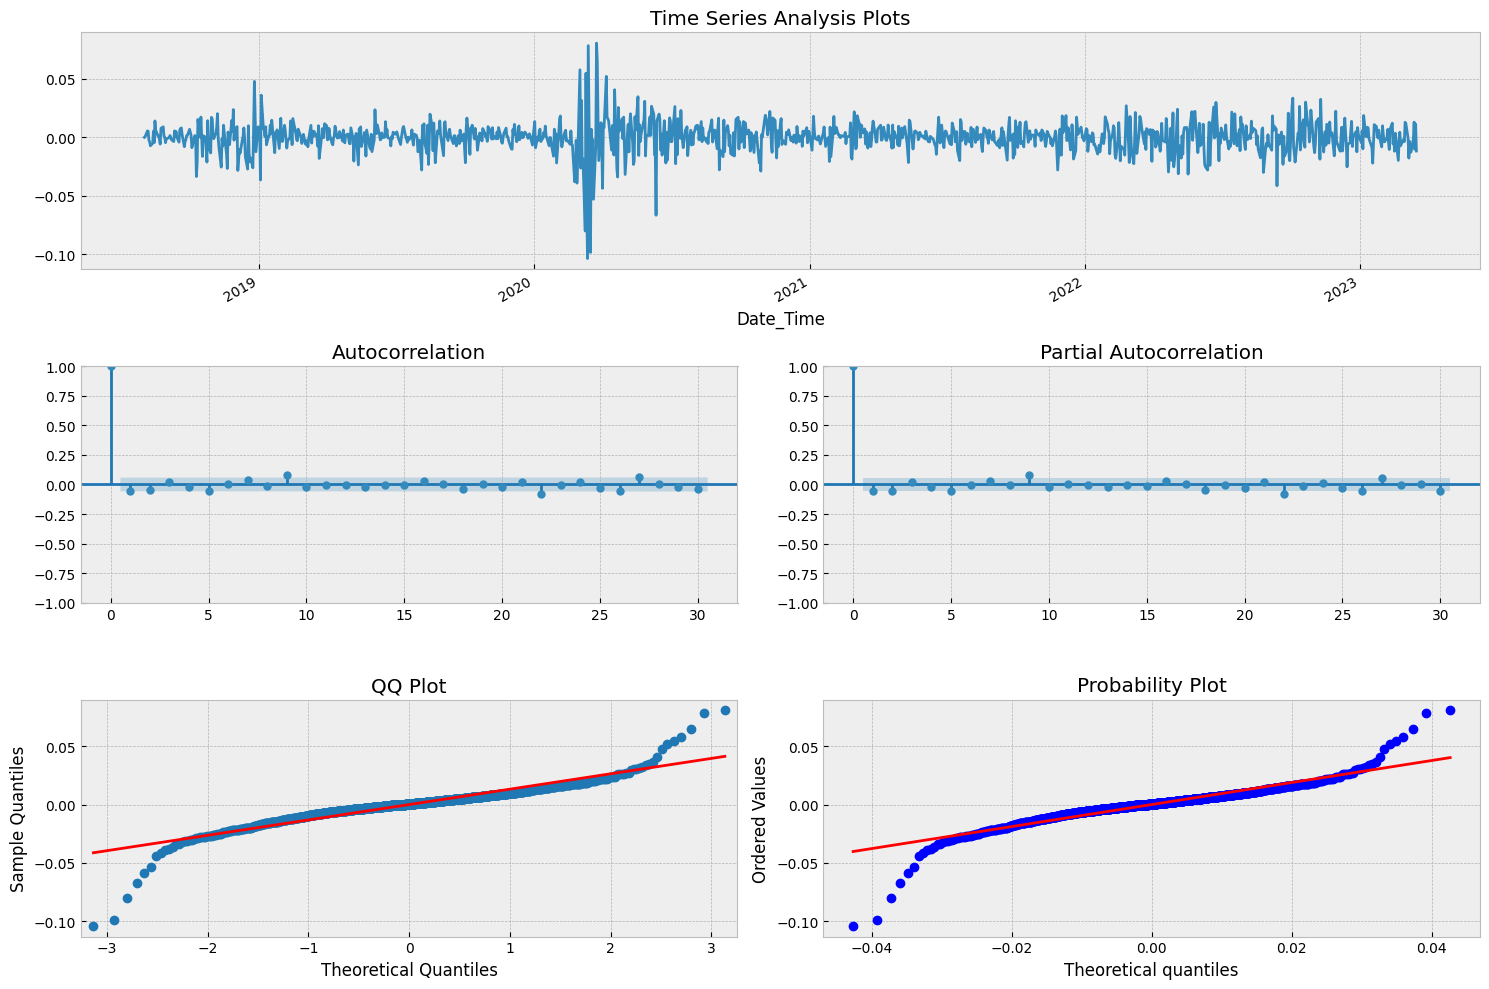

In [5]:
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

im = InsightManager(p)
im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series":"returns"}))
#im.addInsightGenerator(im.createInsightGenerator("AnalysisPlot", opts={"lags":30}))
#im.addInsightGenerator(im.createInsightGenerator("OHLCPlot"))
#im.addInsightGenerator(im.createInsightGenerator("PerfSummary", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
#im.addInsightGenerator(im.createInsightGenerator("StatisticalTests", opts={"baseline": p.assets[0], "level": .95, "iterations":10000}))
    
results = im.generateInsights()

In [12]:
results["ARIMAFit"].resid
tsplot(results["ARIMAFit"].resid)
# TODO : Be able to add any ts to IM for tsplot
#tsplot(p.assets[1].returns["Close"])
#array([ 1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.])
#array([ 1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.])

NameError: name 'tsplot' is not defined

In [13]:
predictions = assembly.get_predictions_with_raw_data(marketData.xs("DOW"), training_id="mlmodel")
predictions

,0,1,2,3,4,5,6,7,8,9,y_pred0
Date_Time,,,,,,,,,,,
2018-08-02 15:00:00-04:00,0.111111,0.854167,0.000000,0.819444,0.805556,1.000000,0.319444,0.486111,0.284613,1.0,6.081961e-01
2018-08-03 15:00:00-04:00,0.367318,1.000000,0.132920,0.767032,0.767032,0.911863,0.000000,0.457361,0.082569,1.0,5.719656e-01
2018-08-06 15:00:00-04:00,0.806915,1.000000,0.026677,0.110852,0.112147,0.772727,0.000000,0.584823,0.302531,0.0,1.670068e-02
2018-08-07 15:00:00-04:00,0.739247,1.000000,0.000000,0.499866,0.496660,0.818595,0.189153,0.526583,0.145812,0.0,5.727510e-01
2018-08-08 15:00:00-04:00,0.258850,0.931969,0.000000,0.926438,0.926715,1.000000,0.621681,0.863938,0.141364,0.0,4.995912e-03
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13 15:00:00-04:00,0.291276,0.734563,0.000000,0.645286,0.644230,1.000000,0.583926,0.742167,0.889658,0.0,4.920740e-01
2023-03-14 15:00:00-04:00,0.930287,1.000000,0.156444,0.345516,0.345382,0.572711,0.000000,0.302435,0.929334,1.0,8.946470e-01
2023-03-15 15:00:00-04:00,0.036753,0.534095,0.000000,0.461735,0.474115,1.000000,0.309948,0.827428,1.471107,1.0,1.923854e-16


In [17]:
mlutils.evaluate(ppl.onehot(predictions[["y_pred0"]].values), ppl.onehot(predictions[[9]].values), threshold=0.5)

Won : 576.0
Lost : 579.0
Total : 1155.0
Diff : -3.0
Edge : -0.2597402597402597%
IR : -0.08827348


0.4987013

In [18]:
mlutils.evaluate(ppl.onehot(np.ones(predictions[[9]].values.shape)), ppl.onehot(predictions[[9]].values), threshold=0.5)

Won : 562.0
Lost : 593.0
Total : 1155.0
Diff : -31.0
Edge : -2.683982683982684%
IR : -0.91215926


0.48658007

In [117]:
import pandas as pd
import numpy as np
from tradeframework.api.core import Model
import statsmodels.api as sm
from typing import Literal
from tqdm import tqdm


class ARIMA(Model):
    """Creates a predictive model based on an ARIMA timeseries model"""

    def __init__(self, env, AR=0, I=0, MA=0, window=1000, fit: Literal["fitAll", "fitWindow", "fitOnce", "inSample"] = "inSample", params=None, barOnly=True):
        Model.__init__(self, env, window)
        self.AR = AR
        self.I = I
        self.MA = MA
        self.fit = fit
        self.params = params
        self.barOnly = barOnly

    def getSignals(self, window, idx=0):

        signals = pd.DataFrame(
            np.zeros((len(window), 2)),
            index=window.index,
            columns=["bar", "gap"],
        )

        if self.fit == "inSample" or self.params is not None:
            
            # For development and analysis purposes, get "predictions" of in-sample values
            model = sm.tsa.arima.ARIMA(window["Close"].values, order=(self.AR, self.I, self.MA))
            
            if self.params is not None:
                # Re-use provided model paramaters
                self.result = model.filter(params=self.params) 
            else:
                self.result = model.fit()

            predictions = self.result.predict(start=0, end=len(window)-1)
                
            predictionSignals = np.sign(
                predictions - window["Close"].shift().values
            )

            predictionSignals = pd.DataFrame(
                np.array([predictionSignals, predictionSignals]).T,
                index=window.index,
                columns=["bar", "gap"],
            )
            
        elif len(window) > self.window:

            dataLen = len(window) - self.window
            res = sm.tsa.arima.ARIMA(
                window[: self.window]["Close"].values, order=(self.AR, self.I, self.MA)
            ).fit()
            
            if self.fit == "fitOnce":            

                # Fit to an initial window, then predict all based on fitted model.
                res = res.append(window[self.window:]["Close"].values)    
                predictions = res.predict(start=self.window, end=len(window)-1)
                    
            else:
                predictions = np.array([res.forecast()[0]])

                for i in tqdm(range(1, dataLen)):
                    if self.fit == "fitAll":
                        # Fit to an ever increasing window and predict next step

                        predictions = np.array([res.forecast()[0]])
                        res = res.append(
                            window[self.window + i - 1 : self.window + i]["Close"].values,
                            refit=True
                        )
                    elif self.fit == "fitWindow":
                        # Fit to an rolling window and predict next step
                        res = sm.tsa.arima.ARIMA(
                            window[i:i+self.window]["Close"].values, order=(self.AR, self.I, self.MA)
                        ).fit()
                        
                    predictions = np.append(predictions, res.forecast()[0])

            predictionSignals = np.sign(
                predictions - window[self.window - 1 : -1]["Close"].values
            )

            predictionSignals = pd.DataFrame(
                np.array([predictionSignals, predictionSignals]).T,
                index=window[self.window :].index,
                columns=["bar", "gap"],
            )

        if self.barOnly:
            predictionSignals["gap"] = 0

        signals.update(predictionSignals)

        return signals[idx:]


In [33]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 9498#24*5*4*3
x = x.iloc[-window-100:]
r = len(x) - window
predictions = np.array([sm.tsa.arima.ARIMA(x[i:i+window]["Close"].values, order=(3, 1, 5)).fit().forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

array([ 1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.])

In [238]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-1000:]
r = len(x) - window
params = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit().params
predictions = np.array([sm.tsa.arima.ARIMA(x[i:i+window]["Close"].values, order=(3, 1, 5)).filter(params).forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([-1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
       -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
        1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,
        1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1

In [280]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
predictions = np.array([res.apply(x[i:i+window]["Close"].values, refit=True).forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

array([ 1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.])

In [290]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-100:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = np.array([res.forecast()[0]])
for i in range(1, r):
    res = res.append(x[window+i-1:window+i]["Close"].values, refit=True)
    #print(x[window+i-1:window+i]["Close"].values)
    predictions = np.append(predictions, res.forecast()[0])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([-1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,
        1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,
       -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
       -1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.])

In [62]:
import statsmodels.api as sm
x = marketData.xs("DOW")
#window = 24*5*4*3
#x = x.iloc[-10:]
#r = len(x) - window
res = sm.tsa.arima.ARIMA(x["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = res.predict(start=len(x)-10, end=len(x)-1)
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

ValueError: operands could not be broadcast together with shapes (10,) (8068,) 

In [190]:
import statsmodels.api as sm
y = marketData.xs("DOW")
window = 24*5*4*3
x = y.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = np.array([res.forecast()[0]])
for i in range(1, r):
    res = res.extend(x[window+i-1:window+i]["Close"].values)
    #print(x[window+i-1:window+i]["Close"].values)
    predictions = np.append(predictions, res.forecast()[0])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([ 1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.])

In [112]:
import statsmodels.api as sm
y = marketData.xs("DOW")
window = 24*5*4*3
x = y.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(4,1,3)).fit()
#print(x[:window]["Close"].values)
#predictions2 = np.array([res.forecast()[0]])

result = res.append(x[window:]["Close"].values)
    #print(x[window+i-1:window+i]["Close"].values)
predictions2 = result.predict(start=len(x)-10, end=len(x)-1)
signals2 = np.sign(predictions2 - x[window-1:-1]["Close"].values)
signals2

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([ 1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.])

In [106]:
predictions2

array([32245.82203025, 32247.70379636, 32247.58775146, 32007.59730162,
       31851.92708551, 31808.49112529, 31901.06410835, 31912.91038558,
       31809.23428615, 31860.44674748])

In [73]:
mod = sm.tsa.arima.ARIMA(x[1:]["Close"].values, order=(1, 1, 0)).filter(res.params)
result.initialize(mod, res.params)

In [107]:
mod = sm.tsa.arima.ARIMA(x[window:]["Close"].values, order=(1, 1, 0))
res2 = mod.filter(res.params)
#res2.initialize(mod, params=res.params)

In [108]:
res2.predict()

array([    0.        , 32257.63030248, 32247.58775146, 32007.59730162,
       31851.92708551, 31808.49112529, 31901.06410835, 31912.91038558,
       31809.23428615, 31860.44674748])

In [109]:
res2.predict()

array([    0.        , 32257.63030248, 32247.58775146, 32007.59730162,
       31851.92708551, 31808.49112529, 31901.06410835, 31912.91038558,
       31809.23428615, 31860.44674748])

In [114]:
res2.params

array([2.10321582e-02, 1.49452129e+04])

In [113]:
res.params

array([-9.93115257e-01, -1.23047954e-01,  4.73227172e-01, -4.17102544e-02,
        1.01873311e+00,  1.22286132e-01, -5.32034052e-01,  1.48711161e+04])

In [18]:
y = marketData.xs("DOW")
len(y)

9508

In [289]:
sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).filter(params).forecast()

array([32228.23928744])

In [224]:
import tradeframework.operations.utils as utils
np.log(utils.getPeriodReturns(p.returns) + 1)[-5:].values[0][0]


-2.448366808491554e-05

In [231]:
p.assets[1].returns

,Open,Close
Date_Time,,
2013-01-01 05:00:00+00:00,0.0,0.000000
2013-01-01 22:15:00+00:00,0.0,0.000000
2013-01-02 05:00:00+00:00,0.0,0.000000
2013-01-02 14:30:00+00:00,0.0,0.000000
2013-01-02 14:35:00+00:00,0.0,0.000000
...,...,...
2023-03-17 20:00:00+00:00,0.0,-0.000069
2023-03-17 20:05:00+00:00,0.0,0.000000
2023-03-17 20:10:00+00:00,0.0,0.000000
